# Using training data
Comparing a naive method (sum of scores) against a machine learning benchmark

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, \
    balanced_accuracy_score, precision_score, recall_score, f1_score


sns.set(style='whitegrid')

In [10]:
objects_path = "/Volumes/Kalyan_SSD/SMG/disambiguation/objects_131120/train/"
people_path = "/Volumes/Kalyan_SSD/SMG/disambiguation/people_281020/train/"
orgs_path = "/Volumes/Kalyan_SSD/SMG/disambiguation/organisations_021120/train/"

X_obj = np.load(objects_path + "X.npy")
y_obj = np.load(objects_path + "y.npy")
X_peo = np.load(people_path + "X.npy")
y_peo = np.load(people_path + "y.npy")
X_org = np.load(orgs_path + "X.npy")
y_org = np.load(orgs_path + "y.npy")


data = {
    "objects": {"X": X_obj, "y": y_obj},
    "people": {"X": X_peo, "y": y_peo},
    "orgs": {"X": X_org, "y": y_org},
}

for k,v in data.items():
    print(v['X'].shape, v['y'].shape)

(720, 5) (720,)
(57887, 8) (57887,)
(12404, 5) (12404,)


In [46]:
def plot_curves(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_pred_proba)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(18,4))

    # plot ROC curve
    ax1.plot(fpr, tpr)
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    # roc_auc_score(y_true, pairs_test['X_sum_norm'])
    sns.despine()

    # plot TPR, FPR against threshold
    ax2.plot(thresholds, fpr, label='FPR')
    ax2.plot(thresholds, tpr, label='TPR')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('threshold')
    ax2.set_ylabel('TPR/FPR')
    ax2.legend(loc="best")
    ax2.set_title('TPR & FPR over Threshold')
    sns.despine();

    # plot precision-recall curve
    ax3.plot(recall, precision)
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('recall')
    ax3.set_ylabel('precision')
    ax3.set_title('Precision-Recall Curve')
    sns.despine();

## 1. Train-test split

---objects---
(540, 5) (540,) (180, 5) (180,)
---people---
(43415, 8) (43415,) (14472, 8) (14472,)
---orgs---
(9303, 5) (9303,) (3101, 5) (3101,)


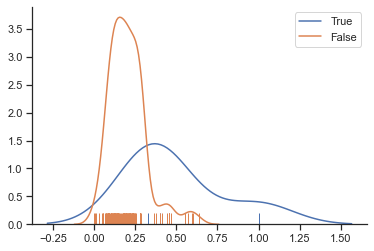

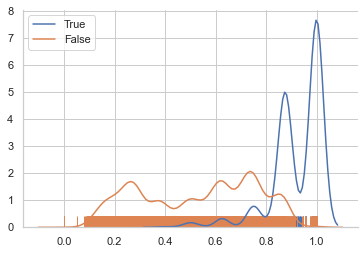

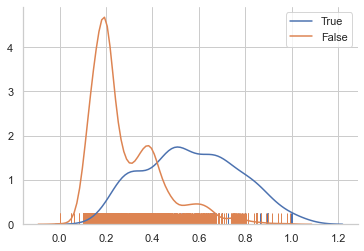

In [27]:
def plot_X_sum_dist(X_sum, k):
    _, _ = plt.subplots()
    sns.set_style('ticks')
    
    X_sum_y_true = data[k]['X_test_sum_norm'][np.where(data[k]['y_test'] == True)]
    X_sum_y_false = data[k]['X_test_sum_norm'][np.where(data[k]['y_test'] == False)]

    sns.distplot(X_sum_y_true, hist=False, rug=True, label='True')
    sns.distplot(X_sum_y_false, hist=False, rug=True, label='False')
    sns.despine()
    sns.set_style('whitegrid')

for k, v in data.items():
    print(f"---{k}---")
    X_train, X_test, y_train, y_test = \
        train_test_split(v['X'], v['y'], test_size=0.25, random_state=42, stratify=v['y'])

    data[k]['X_train'] = X_train
    data[k]['X_test'] = X_test
    data[k]['y_train'] = y_train
    data[k]['y_test'] = y_test
    
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    X_sum = X_test.sum(axis=1)
    data[k]['X_test_sum_norm'] = minmax_scale(X_sum)
    
    plot_X_sum_dist(X_sum, k)


In [64]:
# take 0.8 as a threshold from the above plot
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]
above_threshold = lambda x: x >= threshold

for k,v in data.items():
    print(f"---{k}---")
    
    # 
    ap = []
    ba = []
    p = []
    r = []
    f = []
    for threshold in thresholds:
        y_pred_sum = [above_threshold(i) for i in data[k]['X_test_sum_norm']]
        ap.append(average_precision_score(data[k]['y_test'], y_pred_sum))
        ba.append(balanced_accuracy_score(data[k]['y_test'], y_pred_sum))
        p.append(precision_score(data[k]['y_test'], y_pred_sum))
        r.append(recall_score(data[k]['y_test'], y_pred_sum))
        f.append(f1_score(data[k]['y_test'], y_pred_sum))

    max_precision_idx = np.argmax(ap)
    
    print(f"best threshold: {thresholds[max_precision_idx]}")
    print(f"average precision: {ap[max_precision_idx]}")
    print(f"balanced accuracy: {ba[max_precision_idx]}")
    print(f"precision: {p[max_precision_idx]}")
    print(f"recall: {r[max_precision_idx]}")
    print(f"F1: {f[max_precision_idx]}")
        

---objects---
best threshold: 0.7
average precision: 0.22222222222222224
balanced accuracy: 0.6
precision: 1.0
recall: 0.2
F1: 0.33333333333333337
---people---
best threshold: 0.9
average precision: 0.509827732004677
balanced accuracy: 0.7771394333297015
precision: 0.8736383442265795
recall: 0.5584958217270195
F1: 0.6813933729821581
---orgs---
best threshold: 0.5
average precision: 0.18406559847348225
balanced accuracy: 0.7837992258303781
precision: 0.25326370757180156
recall: 0.6643835616438356
F1: 0.36672967863894135


### 2.2 Machine Learning Classifier

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC

#### 2.2.1 Logistic regression

average precision: 0.8845207219933462
precision @ 0.15: 0.5546218487394958
recall @ 0.15: 0.9192200557103064
f1 @ 0.15: 0.6918238993710691
balanced accuracy @ 0.15: 0.9403429055634562


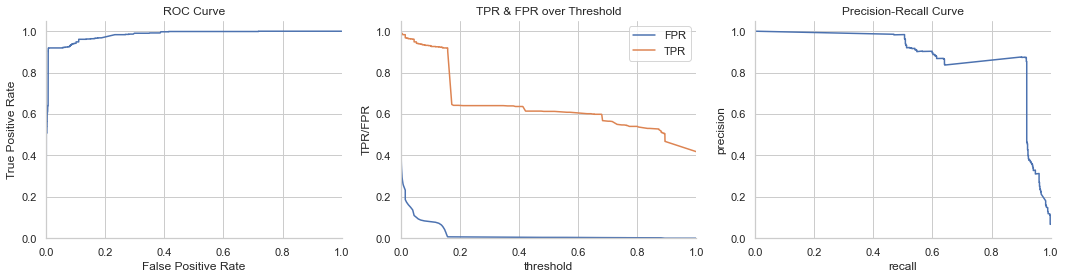

In [73]:
k = 'people'

logr = LogisticRegression(random_state=42).fit(data[k]['X_train'], data[k]['y_train'])
y_pred_proba_logr = logr.predict_proba(data[k]['X_test'])[:,1]

# best for people: 0.15, orgs: 0.1
threshold_logr = 0.15
y_pred_logr = y_pred_proba_logr >= threshold_logr

plot_curves(data[k]['y_test'], y_pred_proba_logr)

print(f"average precision: {average_precision_score(data[k]['y_test'], y_pred_proba_logr)}") 
print(f"precision @ {threshold_logr}: {precision_score(data[k]['y_test'], y_pred_logr)}")
print(f"recall @ {threshold_logr}: {recall_score(data[k]['y_test'], y_pred_logr)}")
print(f"f1 @ {threshold_logr}: {f1_score(data[k]['y_test'], y_pred_logr)}")
print(f"balanced accuracy @ {threshold_logr}: {balanced_accuracy_score(data[k]['y_test'], y_pred_logr)}")

#### 2.2.2 Decision tree

balanced accuracy @ 0.2: 0.9331038638944904
precision @ 0.2: 0.5409836065573771
recall @ 0.2: 0.9041095890410958
f1 @ 0.2: 0.676923076923077
average precision: 0.678693940037124


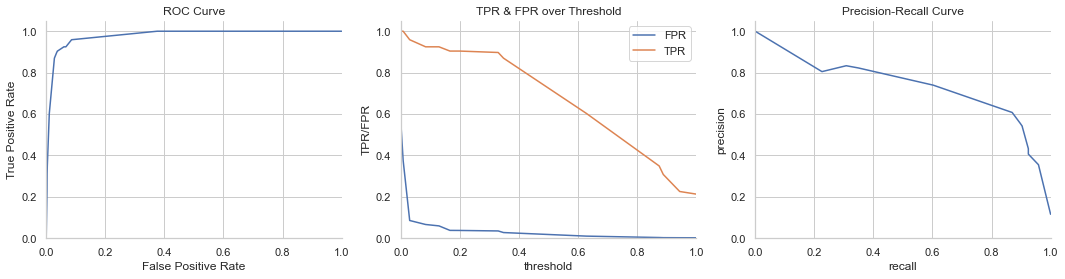

In [81]:
k = 'orgs'

dtc = DecisionTreeClassifier(random_state=42, max_depth=5).fit(data[k]['X_train'], data[k]['y_train'])
y_pred_proba_dtc = dtc.predict_proba(data[k]['X_test'])[:,1]

plot_curves(data[k]['y_test'], y_pred_proba_dtc)

# best for people: 0.5
threshold_dtc = 0.2
y_pred_dtc = y_pred_proba_dtc >= threshold_dtc

print(f"balanced accuracy @ {threshold_dtc}: {balanced_accuracy_score(data[k]['y_test'], y_pred_dtc)}")
print(f"precision @ {threshold_dtc}: {precision_score(data[k]['y_test'], y_pred_dtc)}")
print(f"recall @ {threshold_dtc}: {recall_score(data[k]['y_test'], y_pred_dtc)}")
print(f"f1 @ {threshold_dtc}: {f1_score(data[k]['y_test'], y_pred_dtc)}")
print(f"average precision: {average_precision_score(data[k]['y_test'], y_pred_proba_dtc)}")


#### 2.2.3 SVM

In [83]:
k = 'orgs'

svm = LinearSVC(random_state=42).fit(data[k]['X_train'], data[k]['y_train'])
y_pred_svm = svm.predict(data[k]['X_test'])

# plot_curves(y_test, y_pred_proba_svm)

# threshold_svm = 0.5
# y_pred_svm = y_pred_proba_svm >= threshold_svm

print(f"balanced accuracy: {balanced_accuracy_score(data[k]['y_test'], y_pred_svm)}")
print(f"precision: {precision_score(data[k]['y_test'], y_pred_svm)}")
print(f"recall: {recall_score(data[k]['y_test'], y_pred_svm)}")
print(f"f1: {f1_score(data[k]['y_test'], y_pred_svm)}")
# print(f"average precision: {average_precision_score(y_test, y_pred_proba_svm)}")


balanced accuracy: 0.5903066546137264
precision: 0.45901639344262296
recall: 0.1917808219178082
f1: 0.27053140096618356
